In [178]:
import os
import json

BASEDIR='../model_discovery/model/library/base'

def read_reports(baseline):
    dir = os.path.join(BASEDIR, baseline,'reports')
    reports = {}
    for file in os.listdir(dir):
        if file.startswith('report_'):
            scale = file.split('.')[0].split('_')[1]
            with open(os.path.join(dir, file), 'r') as f:
                reports[scale]=json.load(f)
    return reports

def read_eval_reports(baseline):
    report=read_reports(baseline)
    eval_reports={}
    for i in report:
        eval_reports[i]=report[i]['eval_results.json']
    return eval_reports

def read_eval_results(baseline,mean_group=None):
    reports=read_eval_reports(baseline)
    results={}
    for i in reports:
        results[i]=reports[i]['results']
    return results

BASELINES = ['gpt2','mamba2','ttt']#,'retnet'] #'rwkv6'

GLUE_TASK_LIST = ["cola","mnli","mrpc","qnli","qqp","rte","sst2","wnli"]
STANDARD_EVAL_TASKS = ["hellaswag","piqa","arc_easy","arc_challenge","winogrande", "openbookqa","lambada_openai"]
MEAN_GROUPS = {
    'standard':STANDARD_EVAL_TASKS,
    'blimp':None,
    'inverse_scaling':None,
    'glue':GLUE_TASK_LIST,
    'qa4mre': None,
    'scrolls':None,
}

gpt2_eval_reports=read_eval_reports('gpt2')
gpt2_results=read_eval_results('gpt2')
random_results=read_eval_results('RANDOM')['0']
all_results={}
for i in BASELINES:
    all_results[i]=read_eval_results(i)

#### Print datasets and metrics

In [179]:
random_results
metrics={}
for i in random_results:
    res=random_results[i]
    alias=res['alias']
    for m in res:
        if m=='alias': continue
        if '_stderr' in m: continue
        if m not in metrics:
            metrics[m]=[]
        metrics[m].append(alias)
for m in metrics:
    print(m)
    print(metrics[m])

acc,none
['arc_challenge', 'arc_easy', 'blimp_adjunct_island_filtered', 'blimp_anaphor_gender_agreement_filtered', 'blimp_anaphor_number_agreement_filtered', 'blimp_animate_subject_passive_filtered', 'blimp_animate_subject_trans_filtered', 'blimp_causative_filtered', 'blimp_complex_NP_island_filtered', 'blimp_coordinate_structure_constraint_complex_left_branch_filtered', 'blimp_coordinate_structure_constraint_object_extraction_filtered', 'blimp_determiner_noun_agreement_1_filtered', 'blimp_determiner_noun_agreement_2_filtered', 'blimp_determiner_noun_agreement_irregular_1_filtered', 'blimp_determiner_noun_agreement_irregular_2_filtered', 'blimp_determiner_noun_agreement_with_adj_2_filtered', 'blimp_determiner_noun_agreement_with_adj_irregular_1_filtered', 'blimp_determiner_noun_agreement_with_adj_irregular_2_filtered', 'blimp_determiner_noun_agreement_with_adjective_1_filtered', 'blimp_distractor_agreement_relational_noun_filtered', 'blimp_distractor_agreement_relative_clause_filtered'

In [180]:
def readout_results(results,metrics,mean_group={}):
    out={}
    mean_groups={}
    for group in mean_group:
        mean_groups[group]=0
        out[group]=0
    for i in results:
        res=results[i]
        alias=res['alias']
        for metric in metrics:
            if metric in res:
                mgroup=None
                for group in mean_group:
                    subtasks=mean_group[group]
                    if subtasks is None:
                        if group in alias:
                            mgroup=group
                    else:
                        if alias in subtasks:
                            mgroup=group
                if mgroup:
                    out[mgroup]+=res[metric]
                    mean_groups[mgroup]+=1
                else:
                    out[alias]=res[metric]
    for group in mean_group:
        out[group]=out[group]/mean_groups[group]
    return out

def readout_allresults(allresults,metrics,mean_group={}):
    out={}
    for scale in allresults:
        results=allresults[scale]
        out[scale]=readout_results(results,metrics,mean_group)
    return out

def avg_results(results,keyword=None):
    if keyword:
        results=filter_results(results,keyword)
    avg=0
    for i in results:
        avg+=results[i]
    return avg/len(results)

def filter_results(results,keyword):
    out={}
    for i in results:
        if keyword in i:
            out[i]=results[i]
    return out


In [181]:
for i in all_results:
    print(i,all_results[i].keys())  


gpt2 dict_keys(['70M', '14M', '31M'])
mamba2 dict_keys(['14M', '31M'])
ttt dict_keys(['14M', '31M'])


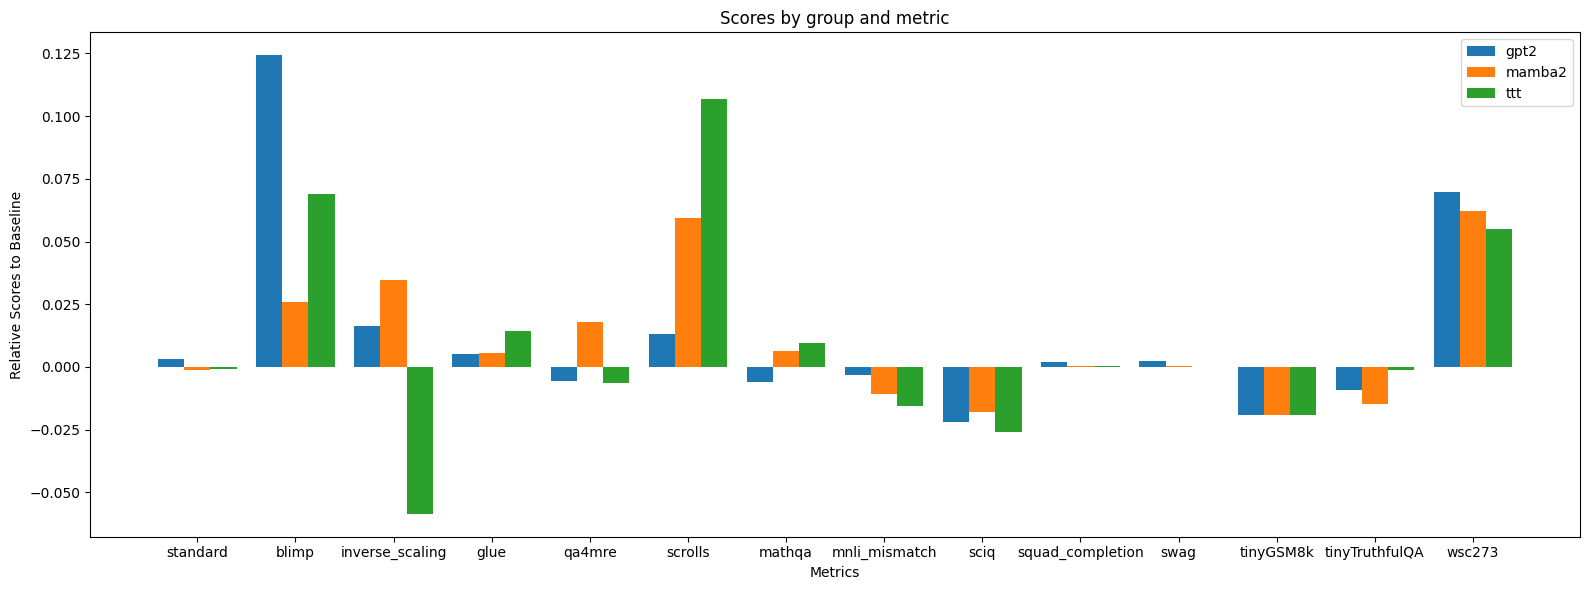

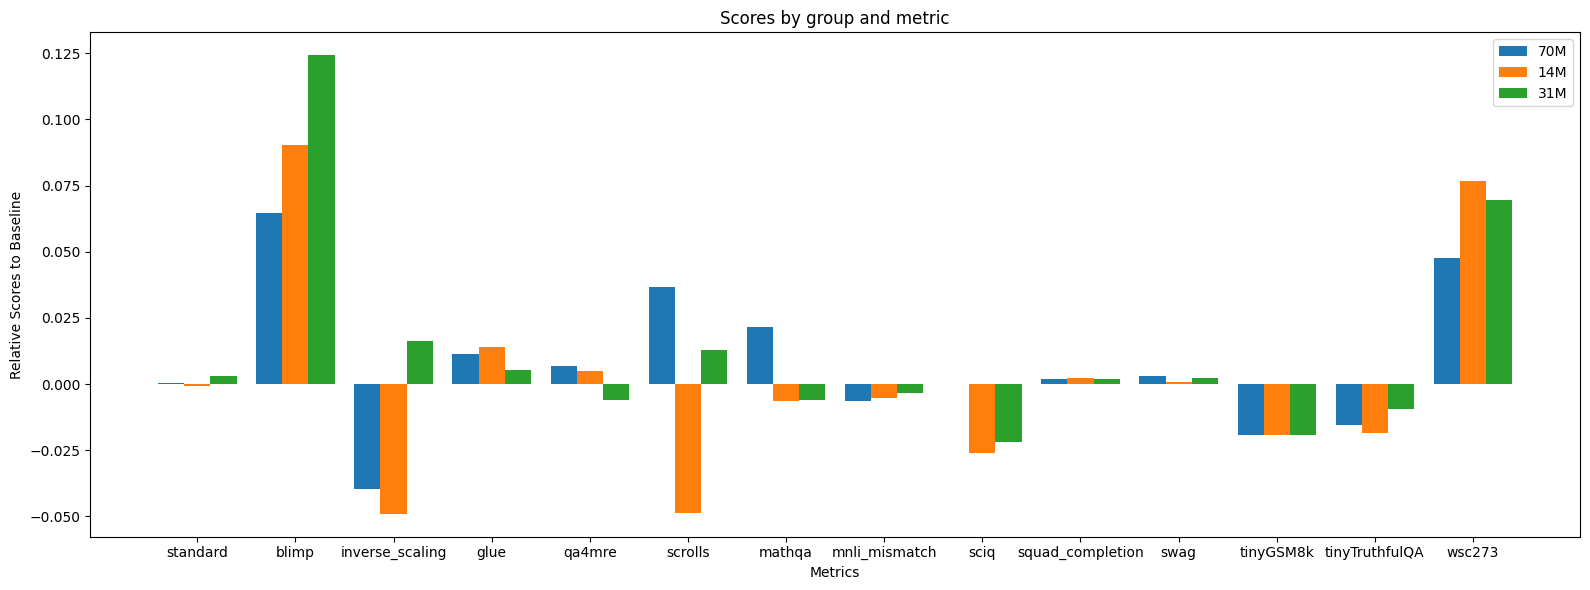

In [182]:
import matplotlib.pyplot as plt
import numpy as np

def plot_grouped_bar_chart(results, baseline=None, ratio=False, title='Scores by group and metric', width=16, height=6):
    """
    Plot a grouped bar chart.
    
    Parameters:
    - data: A dictionary where keys are group names and values are lists of scores for each metric.
    - metrics: A list of metric names.
    - groups: A list of group names.
    - title: The title of the chart.
    """
    groups = list(results.keys())
    metrics = list(results[groups[0]].keys())
    data={}
    for group in groups:
        data[group]=[]
        for metric in metrics:
            score=results[group][metric]
            if baseline:
                score-=baseline[metric]
                if ratio:
                    score/=baseline[metric]
            data[group].append(score)
    x = np.arange(len(metrics))  # the label locations
    bar_width = 0.8 / len(groups)  # the width of the bars, dynamically adjusted based on number of groups
    
    fig, ax = plt.subplots(figsize=(width, height))
    
    for i, group in enumerate(groups):
        ax.bar(x + i * bar_width - bar_width * (len(groups) - 1) / 2, data[group], bar_width, label=group)
    
    # Add some text for labels, title, and custom x-axis tick labels, etc.
    
    ax.set_xlabel('Metrics')
    if baseline:
        if ratio:
            ax.set_ylabel('Relative Ratio to Baseline')
        else:
            ax.set_ylabel('Relative Scores to Baseline')
    else:
        ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    
    fig.tight_layout()
    
    plt.show()

metrics=['acc,none','mcc,none','em,none','contains,none','exact_match,strict-match','exact_match,flexible-extract']#,'perplexity,none']

gpt2_accs = readout_allresults(gpt2_results,metrics,mean_group=MEAN_GROUPS)
random_acc = readout_results(random_results,metrics,mean_group=MEAN_GROUPS)
all_accs = {}
for i in all_results:
    all_accs[i]=readout_allresults(all_results[i],metrics,mean_group=MEAN_GROUPS)
    
all_acc_14M = {}
for i in all_accs:
    all_acc_14M[i]=all_accs[i]['31M']
# all_acc_14M['random']=random_acc
# gpt2_accs['random']=random_acc


ratio=False
baseline=random_acc
plot_grouped_bar_chart(all_acc_14M,baseline,ratio)
plot_grouped_bar_chart(gpt2_accs,baseline,ratio)
